# Etude du phénomène El Niño

**Auteur : FERRY Frédéric (DESR/ENM/C3M) - novembre 2022**

Le phénomène El Niño désigne un phénomène climatique régional qui se caractérise par une élévation anormale de la température de l'eau dans la partie est de l'océan Pacifique sud. Le phénomène El Niño est relié à un cycle de variation de la pression atmosphérique globale entre l'est et l'ouest du Pacifique : l'oscillation australe. D'où l'appellation ENSO (El Niño-Southern Oscillation) Le phénomène El Niño est la conséquence régionale d'une perturbation dans la circulation atmosphérique générale. Son apparition déplace les zones de précipitations vers l'est dans l’océan Pacifique et empêche la remontée d'eau froide (« upwelling ») le long des côtes d’Amérique du Sud, ce qui coupe la source de nutriments pour la faune de ces eaux et y nuit considérablement à l’industrie de la pêche.

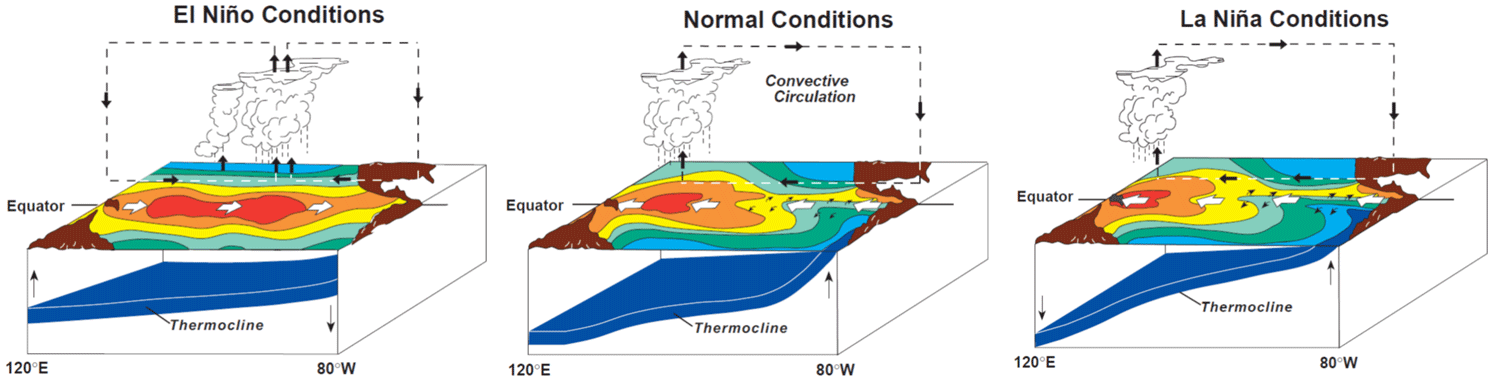

Concepts Python illustrés :
- Exploitation de fichiers au format netcdf (xarray)
- Calcul de climatologies et d'anomalies
- Diagrammes temps-longitude de Hovmoller (matplotlib)
- Tracé de cartes (cartopy)
- Exploitation et tracé de séries temporelles (pandas)
- Filtrage passe-bas de séries temporelles (scipy)
- Réalisation de cartes "composites"
- Analyse en composantes principales (eofs)

In [1]:
import os

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import ImageGrid

import pandas as pd
from pandas import Series
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy.signal import butter, lfilter, filtfilt

# Partie 1 : étude des données mensuelles de température de surface de la mer (SST)
https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html

In [2]:
year1='1982-01-01'
year2='2021-12-01'

f    = xr.open_dataset("./data/sst.mnmean.nc").sel(time=slice(year1,year2))
lat  = f.lat.values
lon  = f.lon.values
time  = f.time.values

sst = f['sst']
print(sst)
print(sst.shape)

<xarray.DataArray 'sst' (time: 480, lat: 180, lon: 360)>
[31104000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2021-12-01
Attributes: (12/13)
    long_name:             Monthly Mean of Sea Surface Temperature
    unpacked_valid_range:  [-5. 40.]
    actual_range:          [-1.7999996 35.56862  ]
    units:                 degC
    precision:             2
    var_desc:              Sea Surface Temperature
    ...                    ...
    level_desc:            Surface
    statistic:             Mean
    parent_stat:           Weekly Mean
    standard_name:         sea_surface_temperature
    cell_methods:          time: mean (monthly from weekly values interpolate...
    valid_range:           [-500 4000]
(480, 180, 360)


In [3]:
f_mean = f.groupby('time.month').mean('time')
f_anom = f.groupby('time.month') - f_mean

print(f_mean)
print(f_anom)

months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sst_clim = f_mean['sst']
sst_anom = f_anom['sst']
print(sst_clim.shape)
print(sst_anom.shape)

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, month: 12)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, lat, lon) float32 -1.79 -1.79 -1.79 ... -1.79 -1.79 -1.79
<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 480)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 7.153e-07 7.153e-07 ... 7.153e-07
(12, 180, 360)
(480, 180, 360)


In [4]:
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', facecolor='none', name='coastline')

def plot_background(ax):
    ax.add_feature(coast, edgecolor='gray')
    ax.add_feature(cfeature.LAND, zorder=100, facecolor='w', edgecolor='k')
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    ax.set_xticks(np.linspace(-180, 180, 10), crs=ccrs.PlateCarree(central_longitude=190))
    ax.set_yticks(np.linspace(-90, 90, 13), crs=ccrs.PlateCarree(central_longitude=190))
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    return ax

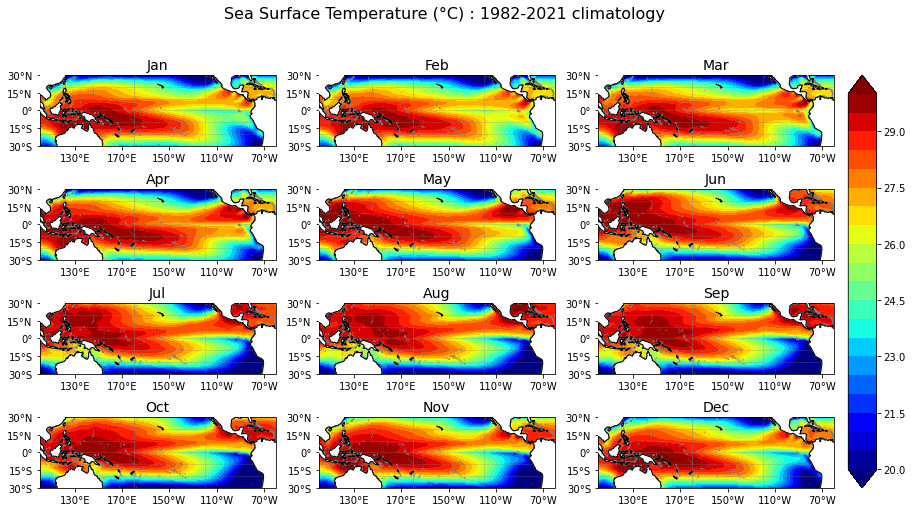

In [5]:
levels = np.arange(20,30.5,0.5)

axes_class = (GeoAxes, dict(map_projection=ccrs.PlateCarree(central_longitude=190)))
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Sea Surface Temperature (°C) : '+year1[0:4]+'-'+year2[0:4]+' climatology', fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(4, 3),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode

for i, ax in enumerate(axgr):
    plot_background(ax)
    bounds = [(100, 300, -30., 30.)] # geographical domain [(lon1, lon2, lat1, lat2)]
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    ax.set_title(months[i], fontsize=14)
    cf = ax.contourf(lon, lat, sst_clim[i,:,:], levels, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
    axgr.cbar_axes[i].colorbar(cf)

figname='./figs/sst_pacific_climatology'
fig.savefig(figname+'.png',bbox_inches='tight')

plt.show()

In [6]:
month_nino='1997-12-01'
month_nina='2010-12-01'

f_nino    = xr.open_dataset("./data/sst.mnmean.nc").sel(time=month_nino)
f_nina    = xr.open_dataset("./data/sst.mnmean.nc").sel(time=month_nina)
f_anom_nino=f_anom.sel(time=month_nino)
f_anom_nina=f_anom.sel(time=month_nina)

sst_nino = f_nino['sst']
sst_nina = f_nina['sst']
sst_anom_nino = f_anom_nino['sst']
sst_anom_nina = f_anom_nina['sst']

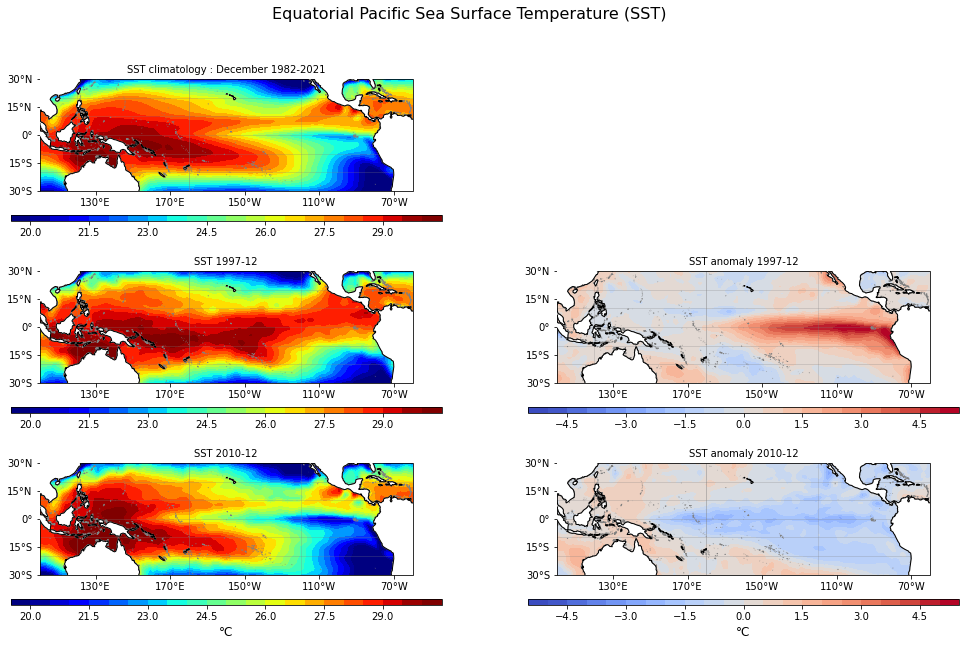

In [7]:
levels2 = np.arange(-5,5.5,0.5)

fig = plt.figure(figsize=(17, 10))
fig.suptitle('Equatorial Pacific Sea Surface Temperature (SST)', fontsize=16)

ax = fig.add_subplot(3, 2, 1, projection=ccrs.PlateCarree(central_longitude=190))
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
plt.title('SST climatology : December '+year1[0:4]+'-'+year2[0:4], fontsize=10, loc='center')
cf = ax.contourf(lon, lat, sst_clim[11,:,:], levels, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.15, extendrect='True')

ax = fig.add_subplot(3, 2, 3, projection=ccrs.PlateCarree(central_longitude=190))
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
plt.title('SST '+month_nino[0:7], fontsize=10, loc='center')
cf = ax.contourf(lon, lat, sst_nino, levels, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.15, extendrect='True')

ax = fig.add_subplot(3, 2, 5, projection=ccrs.PlateCarree(central_longitude=190))
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
plt.title('SST '+month_nina[0:7], fontsize=10, loc='center')
cf = ax.contourf(lon, lat, sst_nina, levels, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.15, extendrect='True')
cb.set_label('°C', fontsize=12)

ax = fig.add_subplot(3, 2, 4, projection=ccrs.PlateCarree(central_longitude=190))
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
plt.title('SST anomaly '+month_nino[0:7], fontsize=10, loc='center')
cf = ax.contourf(lon, lat, sst_anom_nino, levels2, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.15, extendrect='True')

ax = fig.add_subplot(3, 2, 6, projection=ccrs.PlateCarree(central_longitude=190))
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
plt.title('SST anomaly '+month_nina[0:7], fontsize=10, loc='center')
cf = ax.contourf(lon, lat, sst_anom_nina, levels2, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.15, extendrect='True')
cb.set_label('°C', fontsize=12)

figname='./figs/sst_nino_nina'
fig.savefig(figname+'.png',bbox_inches='tight')

plt.show()

In [8]:
f2    = xr.open_dataset("./data/sst.mnmean.nc").sel(time=slice(year1,year2)
                                                   ).sel(lon=slice(120,280)
                                                        ).sel(lat=slice(10,-10)).mean('lat')
f2_mean = f2.groupby('time.month').mean('time')
f2_anom = f2.groupby('time.month') - f2_mean
time2  = f2.time.values
lon2  = f2.lon.values

print(f2_mean)
print(f2_anom)

sst2 = f2['sst']
sst_anom2 = f2_anom['sst']
print(sst2.shape)

<xarray.Dataset>
Dimensions:  (lon: 160, month: 12)
Coordinates:
  * lon      (lon) float32 120.5 121.5 122.5 123.5 ... 276.5 277.5 278.5 279.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, lon) float32 28.74 28.8 28.86 28.86 ... 24.72 24.64 24.6
<xarray.Dataset>
Dimensions:  (lon: 160, time: 480)
Coordinates:
  * lon      (lon) float32 120.5 121.5 122.5 123.5 ... 276.5 277.5 278.5 279.5
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lon) float32 -0.5751 -0.5675 -0.5135 ... -0.578 -0.4695
(480, 160)


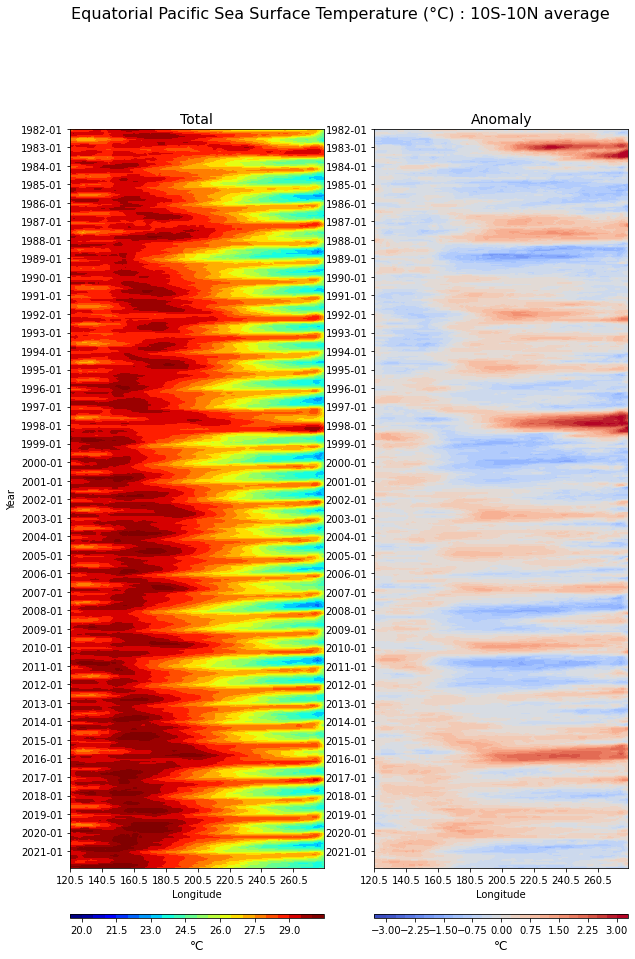

In [9]:
levels1 = np.arange(20,30.5,0.5)
levels2 = np.arange(-3,3.25,0.25)

fig = plt.figure(figsize=(10., 17.))
fig.suptitle('Equatorial Pacific Sea Surface Temperature (°C) : 10S-10N average', fontsize=16)

ax=plt.subplot(1, 2, 1)
ax.set_title('Total', fontsize=14)
plt.ylabel('Year')
plt.xlabel('Longitude')
plt.gca().invert_yaxis()
ax.set_yticks(time[::12])

time  = f.time.values
time_str=[x for x in range(len(time))]
date_str=[x for x in range(len(time))]

for i in range(len(time)):
	time_str[i] = str(time[i])
	date_str[i] = time_str[i][0:7]

ax.set_yticklabels(date_str[::12])
ax.set_xticks(lon2[::20])
ax.set_xticklabels(lon2[::20])
ax.set_xticks(lon2[::20])
cf = ax.contourf(lon2, time2, sst2[:,:], levels=levels1, cmap='jet', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('°C', size='large')

ax=plt.subplot(1, 2, 2)
ax.set_title('Anomaly', fontsize=14)
plt.xlabel('Longitude')
plt.gca().invert_yaxis()
ax.set_yticks(time[::12])
ax.set_yticklabels(date_str[::12])
ax.set_xticks(lon2[::20])
ax.set_xticklabels(lon2[::20])
ax.set_xticks(lon2[::20])
cf = ax.contourf(lon2, time2, sst_anom2[:,:], levels=levels2, cmap='coolwarm', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('°C', size='large')

figname='./figs/sst_pacific_hovmoller'
fig.savefig(figname+'.png',bbox_inches='tight')

plt.show()

# Partie 2 : indices ONI et SOI

- https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni
- http://www.esrl.noaa.gov/psd/data/correlation/nina34.data
- https://www.ncdc.noaa.gov/teleconnections/enso/indicators/soi/
- https://www.cpc.ncep.noaa.gov/data/indices/soi

In [10]:
nino=np.loadtxt('./data/nina34.data',skiprows=2)
nino=nino[2:,1:]
nino=nino.flatten()

dates = pd.date_range('1951', '2023', freq='M')
print(dates)
nino = Series(nino, index=dates)

nino=(nino-nino.mean())/nino.std()
print(nino.mean())
print(nino.std())

nino_smooth=nino.rolling(window=3, center=True).mean()
print(nino_smooth)

DatetimeIndex(['1951-01-31', '1951-02-28', '1951-03-31', '1951-04-30',
               '1951-05-31', '1951-06-30', '1951-07-31', '1951-08-31',
               '1951-09-30', '1951-10-31',
               ...
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', length=864, freq='M')
2.1393380893957532e-14
1.0000000000000004
1951-01-31         NaN
1951-02-28   -0.972068
1951-03-31   -0.173307
1951-04-30    0.581079
1951-05-31    0.864400
                ...   
2022-08-31   -0.876490
2022-09-30   -1.173465
2022-10-31   -1.200773
2022-11-30   -1.166638
2022-12-31         NaN
Freq: M, Length: 864, dtype: float64


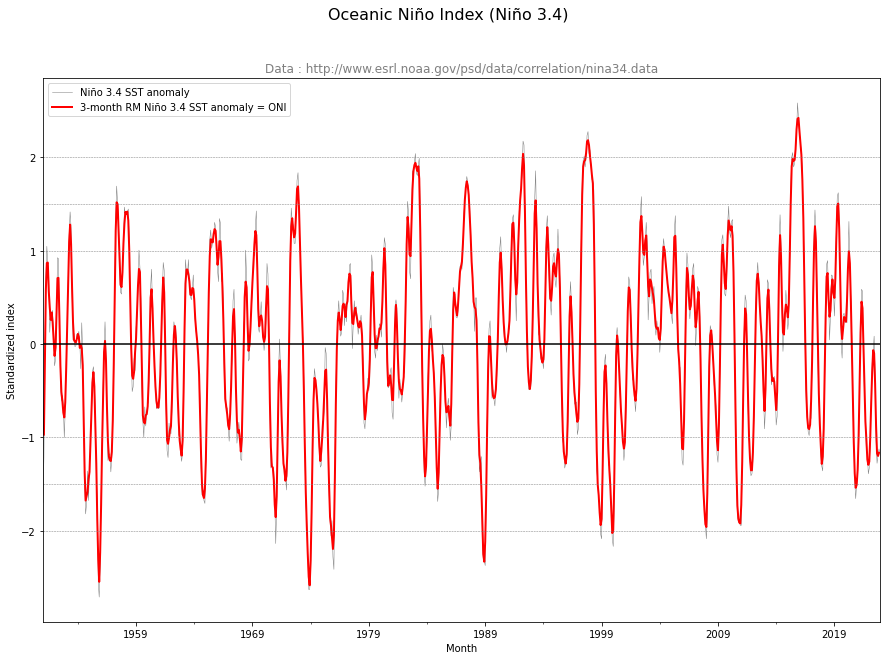

In [11]:
fig=plt.figure(figsize=(15, 10))
fig.suptitle('Oceanic Niño Index (Niño 3.4)', fontsize=16)
plt.title('Data : http://www.esrl.noaa.gov/psd/data/correlation/nina34.data' , fontsize=12, color='grey')
plt.xlabel('Month')
plt.ylabel('Standardized index')

ax = nino.plot(color='grey', linewidth=0.5, alpha=1, label='Niño 3.4 SST anomaly')
ax = nino_smooth.plot(color='red', linewidth=2, label='3-month RM Niño 3.4 SST anomaly = ONI')

plt.axhline(0, color='k')
plt.axhline(1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(1.5, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-1.5, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-2, color='grey', linestyle='--', linewidth=0.5)

plt.legend()

figname='./figs/ONI'
fig.savefig(figname+'.png',bbox_inches='tight')

plt.show()

In [12]:
soi=np.loadtxt('./data/soi.data',skiprows=4)
soi=soi[:,1:]
soi=soi.flatten()

dates = pd.date_range('1951', '2023', freq='M')
print(dates)
soi = Series(soi, index=dates)

soi=(soi-soi.mean())/soi.std()
print(soi.mean())
print(soi.std())

soi_smooth=soi.rolling(window=3, center=True).mean()
print(soi_smooth)

DatetimeIndex(['1951-01-31', '1951-02-28', '1951-03-31', '1951-04-30',
               '1951-05-31', '1951-06-30', '1951-07-31', '1951-08-31',
               '1951-09-30', '1951-10-31',
               ...
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', length=864, freq='M')
-2.0611084855309618e-16
0.9999999999999997
1951-01-31         NaN
1951-02-28    0.652843
1951-03-31    0.015251
1951-04-30   -0.551498
1951-05-31   -0.445232
                ...   
2022-08-31    1.042483
2022-09-30    1.361279
2022-10-31    1.113327
2022-11-30    1.290436
2022-12-31         NaN
Freq: M, Length: 864, dtype: float64


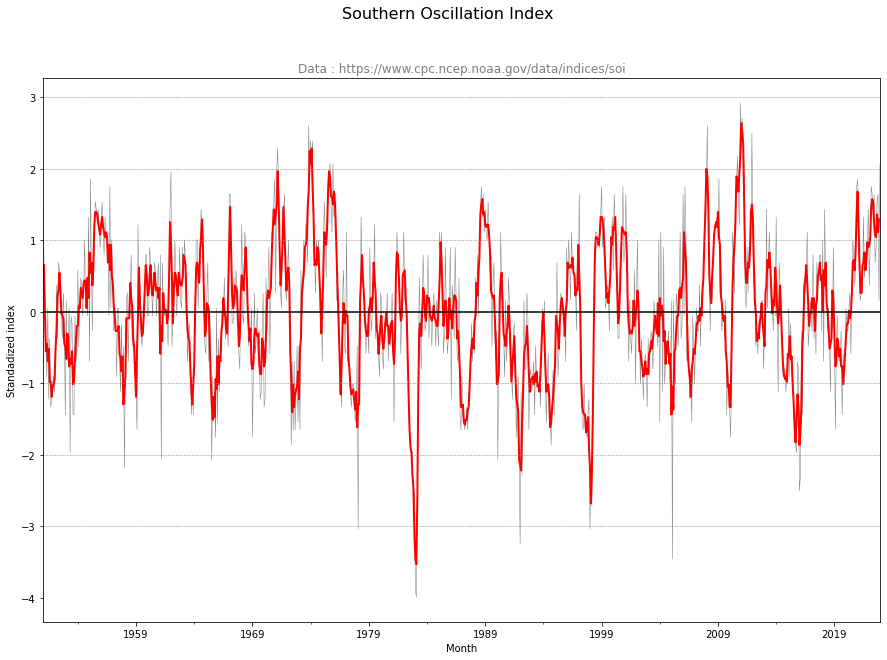

In [13]:
fig=plt.figure(figsize=(15, 10))
fig.suptitle('Southern Oscillation Index', fontsize=16)
plt.title('Data : https://www.cpc.ncep.noaa.gov/data/indices/soi' , fontsize=12, color='grey')
plt.xlabel('Month')
plt.ylabel('Standadized index')

ax = soi.plot(color='grey', linewidth=0.5, alpha=1, label='SOI')
ax = soi_smooth.plot(color='red', linewidth=2, label='3-month RM SOI')

plt.axhline(0, color='k')
plt.axhline(1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(3, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-3, color='grey', linestyle='--', linewidth=0.5)

figname='./figs/soi'
fig.savefig(figname+'.png',bbox_inches='tight')

plt.show()

In [14]:
cor=np.corrcoef(nino_smooth.values[1:-2], soi_smooth.values[1:-2])
print(cor.shape)

(2, 2)


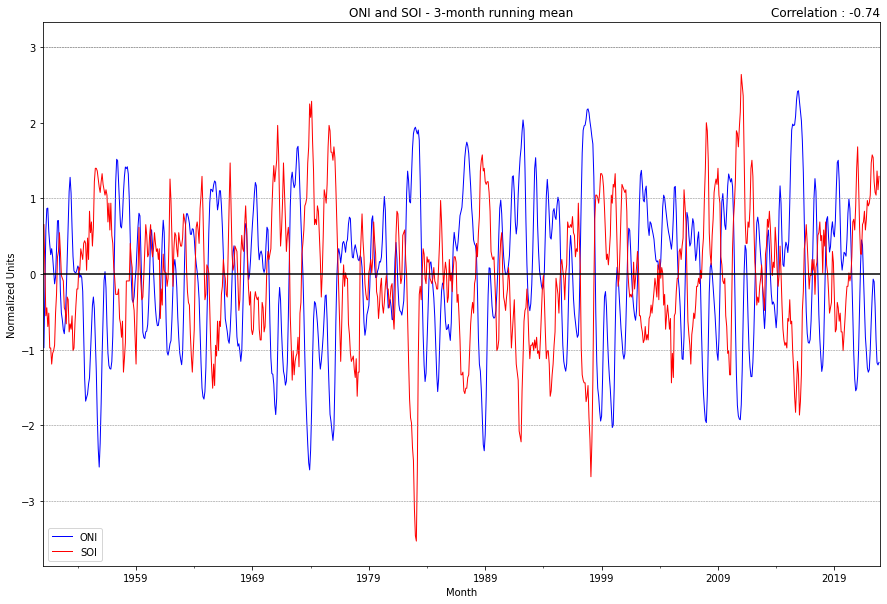

In [15]:
fig=plt.figure(figsize=(15, 10))
plt.title('ONI and SOI - 3-month running mean', loc='center')
plt.title('Correlation : '+str(round(cor[0,1],2)), loc='right')
plt.xlabel('Month')
plt.ylabel('Normalized Units')

ax = nino_smooth.plot(color='b', linewidth=1, label='ONI')
ax = soi_smooth.plot(color='r', linewidth=1, label='SOI')

plt.axhline(0, color='k')
plt.axhline(1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(3, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(3, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-3, color='grey', linestyle='--', linewidth=0.5)

plt.legend()

figname='./figs/oni_vs_soi'
fig.savefig(figname+'.png',bbox_inches='tight')

plt.show()

In [16]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

bsoi24=butter_lowpass_filter(soi, 1/24, 1., order=5)

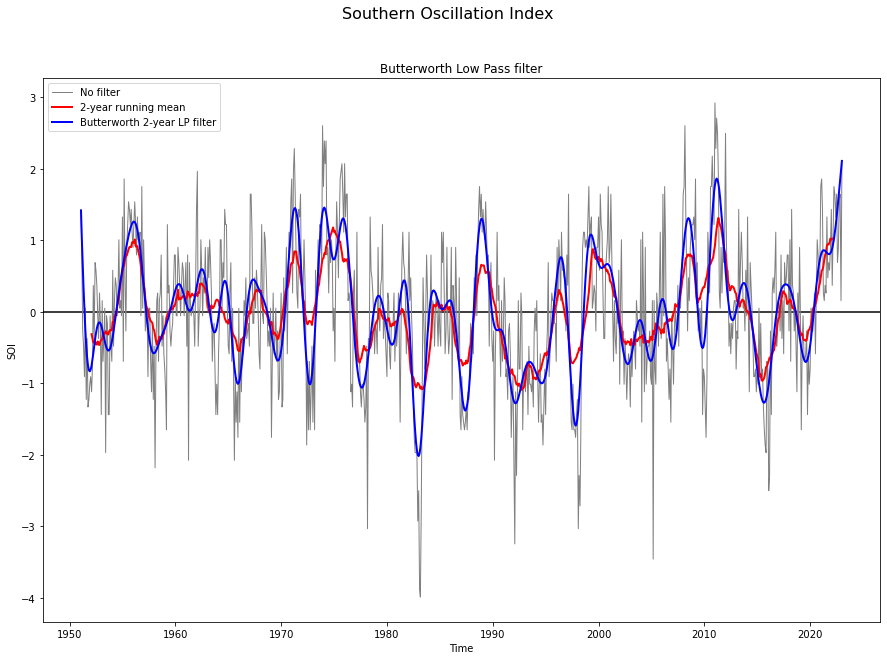

In [17]:
soi24=soi.rolling(24, center=True).mean()

fig=plt.figure(figsize=(15, 10))
fig.suptitle('Southern Oscillation Index', fontsize=16)

ax = plt.subplot(111)
plt.title('Butterworth Low Pass filter', fontsize=12)
plt.xlabel('Time')
plt.ylabel('SOI')
plt.axhline(0, color='k')
raw = ax.plot(dates, soi, color='grey', linewidth=1, linestyle='-', alpha=1, label='No filter')
rm = ax.plot(dates, soi24, color='red', linewidth=2, linestyle='-', label='2-year running mean')
b24 = ax.plot(dates, bsoi24, color='blue', linewidth=2, linestyle='-', label='Butterworth 2-year LP filter')
plt.legend()

figname='./figs/soi_filter1'
fig.savefig(figname+'.png',bbox_inches='tight')

plt.show()

In [18]:
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

window = 49

wgts24 = low_pass_weights(window, 1. / 24.)  #
sum_wgts24 = np.sum(wgts24)
lsoi24=soi.rolling(window=window, center=True).apply(lambda x: np.sum(wgts24*x) / sum_wgts24, raw=False)

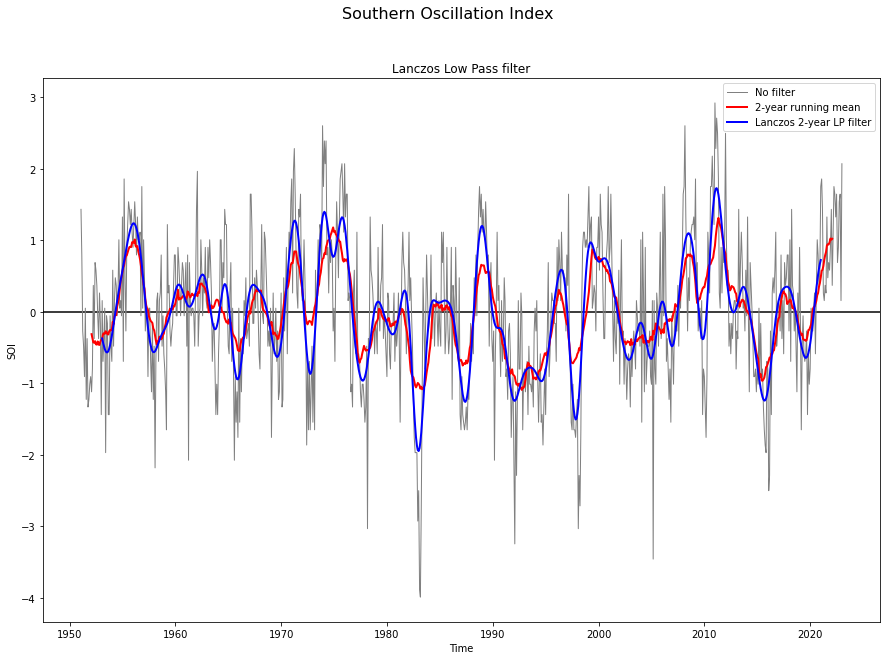

In [19]:
fig=plt.figure(figsize=(15, 10))
fig.suptitle('Southern Oscillation Index', fontsize=16)

ax = plt.subplot(111)
plt.title('Lanczos Low Pass filter', fontsize=12)
plt.xlabel('Time')
plt.ylabel('SOI')
plt.axhline(0, color='k')
raw = ax.plot(dates, soi, color='grey', linewidth=1, linestyle='-', alpha=1, label='No filter')
rm = ax.plot(dates, soi24, color='red', linewidth=2, linestyle='-', label='2-year running mean')
l24 = ax.plot(dates, lsoi24, color='blue', linewidth=2, linestyle='-', label='Lanczos 2-year LP filter')
plt.legend()

figname='./figs/soi_filter2'
fig.savefig(figname+'.png',bbox_inches='tight')

plt.show()

# Partie 3 : composites de température et de précipitations

- Données mensuelles de précipitations : 
https://psl.noaa.gov/data/gridded/data.gpcp.html

- Données mensuelles de température à 2m :
https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.surfaceflux.html

In [20]:
year1='1982-01-01'
year2='2019-12-01'

#--  t data

f3    = xr.open_dataset("./data/air.2m.mon.mean.nc").sel(time=slice(year1,year2))
lat3  = f3.lat.values
time3  = f3.time.values

f3_mean = f3.groupby('time.month').mean('time')
f3_anom = f3.groupby('time.month') - f3_mean

t_mean0 = f3_mean['air']
t0 = f3['air']
t_anom0 = f3_anom['air']

#--  Precipitation data

f4    = xr.open_dataset("./data/precip.mon.mean.nc").sel(time=slice(year1,year2))
lat4  = f4.lat.values
time4  = f4.time.values

f4_mean = f4.groupby('time.month').mean('time')
f4_anom = f4.groupby('time.month') - f4_mean

pr_mean0 = f4_mean['precip']
pr0 = f4['precip']
pr_anom0 = f4_anom['precip']

#--  Add cyclic points

lon0 = t_mean0.coords['lon']
lon_idx = t_mean0.dims.index('lon')
t_mean, lon3 = add_cyclic_point(t_mean0.values, coord=lon0, axis=lon_idx)
t, lon3 = add_cyclic_point(t0.values, coord=lon0, axis=lon_idx)
t_anom, lon3 = add_cyclic_point(t_anom0.values, coord=lon0, axis=lon_idx)

print("Original shape -", t0.shape)
print("New shape -", t.shape)

lon0 = pr_mean0.coords['lon']
lon_idx = pr_mean0.dims.index('lon')
pr_mean, lon4 = add_cyclic_point(pr_mean0.values, coord=lon0, axis=lon_idx)
pr, lon4 = add_cyclic_point(pr0.values, coord=lon0, axis=lon_idx)
pr_anom, lon4 = add_cyclic_point(pr_anom0.values, coord=lon0, axis=lon_idx)

print("Original shape -", pr0.shape)
print("New shape -", pr.shape)

# Open Nino 34 index from 1982-01 to 2019-12
nino=np.loadtxt('./data/nina34_1982-2019.data',skiprows=1)
nino=nino[:,1:]
nino=nino.flatten()
nino=(nino-nino.mean())/nino.std()
nino=np.array(nino)

# Compute t composites

t_elnino=t[nino>=1.5,:,:]
t_elnino_composite=t_elnino.mean(axis=0)
t_lanina=t[nino<=-1.5,:,:]
t_lanina_composite=t_lanina.mean(axis=0)

t_elnino_anom=t_anom[nino>=1.5,:,:]
t_elnino_composite_anom=t_elnino_anom.mean(axis=0)
t_lanina_anom=t_anom[nino<=-1.5,:,:]
t_lanina_composite_anom=t_lanina_anom.mean(axis=0)

# Compute Precipitation composites

pr_elnino=pr[nino>=1.5,:,:]
pr_elnino_composite=pr_elnino.mean(axis=0)
pr_lanina=pr[nino<=-1.5,:,:]
pr_lanina_composite=pr_lanina.mean(axis=0)

pr_elnino_anom=pr_anom[nino>=1.5,:,:]
pr_elnino_composite_anom=pr_elnino_anom.mean(axis=0)
pr_lanina_anom=pr_anom[nino<=-1.5,:,:]
pr_lanina_composite_anom=pr_lanina_anom.mean(axis=0)

Original shape - (456, 94, 192)
New shape - (456, 94, 193)
Original shape - (456, 72, 144)
New shape - (456, 72, 145)


In [21]:
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', facecolor='none', name='coastline')

def plot_background2(ax):
    ax.add_feature(coast, edgecolor='gray')
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    ax.set_xticks(np.linspace(-180, 180, 5), crs=ccrs.PlateCarree(central_longitude=180))
    ax.set_yticks(np.linspace(-90, 90, 7), crs=ccrs.PlateCarree(central_longitude=180))
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    return ax

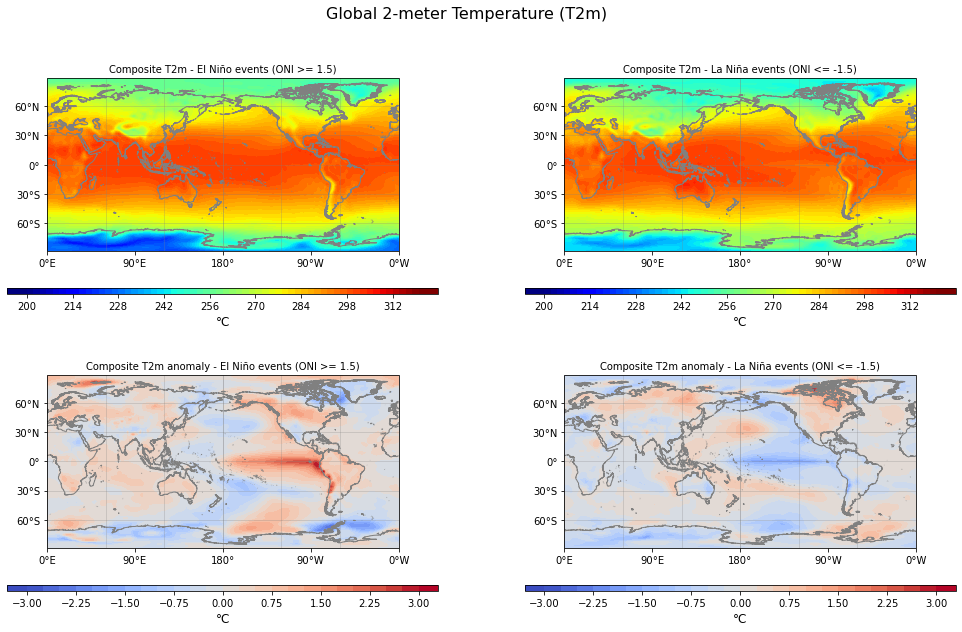

In [22]:
proj=ccrs.PlateCarree(central_longitude=180)
levels_t1 = np.arange(200,322,2)
levels_t2 = np.arange(-3,3.25,0.25)

fig = plt.figure(figsize=(17, 10))
fig.suptitle('Global 2-meter Temperature (T2m)', fontsize=16)

ax = fig.add_subplot(2, 2, 1, projection=proj)
plot_background2(ax)
plt.title('Composite T2m - El Niño events (ONI >= 1.5)', fontsize=10, loc='center')
cf = ax.contourf(lon3, lat3, t_elnino_composite, levels_t1, transform=ccrs.PlateCarree(),
                 cmap='jet', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.15, extendrect='True')
cb.set_label('°C', fontsize=12)

ax = fig.add_subplot(2, 2, 2, projection=proj)
plot_background2(ax)
plt.title('Composite T2m - La Niña events (ONI <= -1.5)', fontsize=10, loc='center')
cf = ax.contourf(lon3, lat3, t_lanina_composite, levels_t1, transform=ccrs.PlateCarree(),
                 cmap='jet', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.15, extendrect='True')
cb.set_label('°C', fontsize=12)

ax = fig.add_subplot(2, 2, 3, projection=proj)
plot_background2(ax)
plt.title('Composite T2m anomaly - El Niño events (ONI >= 1.5)', fontsize=10, loc='center')
cf = ax.contourf(lon3, lat3, t_elnino_composite_anom, levels_t2, transform=ccrs.PlateCarree(),
                 cmap='coolwarm', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.15, extendrect='True')
cb.set_label('°C', fontsize=12)

ax = fig.add_subplot(2, 2, 4, projection=proj)
plot_background2(ax)
plt.title('Composite T2m anomaly - La Niña events (ONI <= -1.5)', fontsize=10, loc='center')
cf = ax.contourf(lon3, lat3, t_lanina_composite_anom, levels_t2, transform=ccrs.PlateCarree(),
                 cmap='coolwarm', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.15, extendrect='True')
cb.set_label('°C', fontsize=12)

figname='./figs/nino_nina_composites_t2m'
fig.savefig(figname+'.png',bbox_inches='tight')

plt.show()

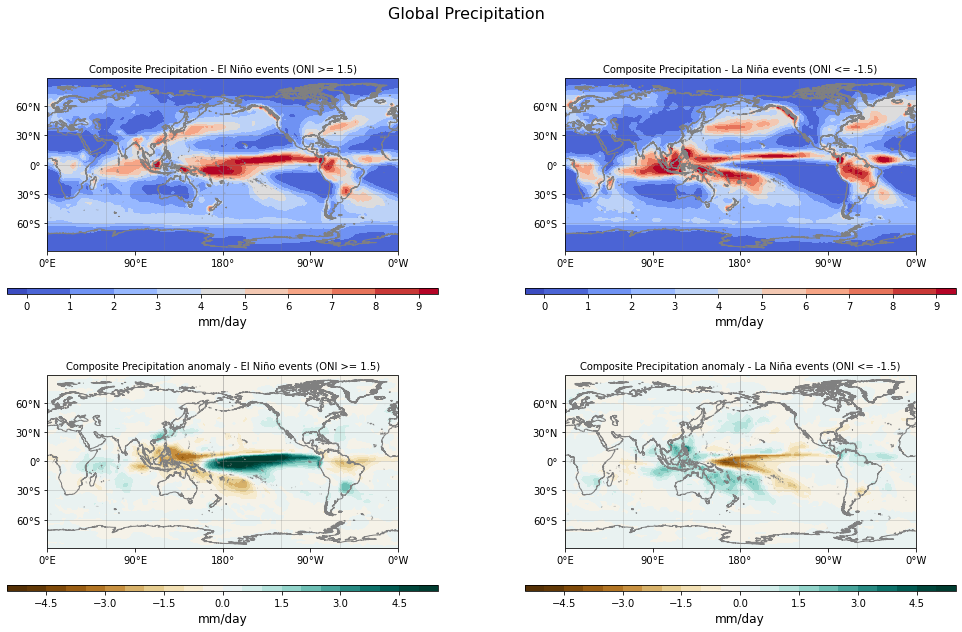

In [23]:
levels1 = np.arange(0,10,1)
levels2 = np.arange(-5,5.5,0.5)

fig = plt.figure(figsize=(17, 10))
fig.suptitle('Global Precipitation', fontsize=16)

ax = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
plot_background2(ax)
plt.title('Composite Precipitation - El Niño events (ONI >= 1.5)', fontsize=10, loc='center')
cf = ax.contourf(lon4, lat4, pr_elnino_composite, levels1, transform=ccrs.PlateCarree(),
                 cmap='coolwarm', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.15, extendrect='True')
cb.set_label('mm/day', fontsize=12)

ax = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
plot_background2(ax)
plt.title('Composite Precipitation - La Niña events (ONI <= -1.5)', fontsize=10, loc='center')
cf = ax.contourf(lon4, lat4, pr_lanina_composite, levels1, transform=ccrs.PlateCarree(),
                 cmap='coolwarm', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.15, extendrect='True')
cb.set_label('mm/day', fontsize=12)

ax = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree(central_longitude=180))
plot_background2(ax)
plt.title('Composite Precipitation anomaly - El Niño events (ONI >= 1.5)', fontsize=10, loc='center')
cf = ax.contourf(lon4, lat4, pr_elnino_composite_anom, levels2, transform=ccrs.PlateCarree(),
                 cmap='BrBG', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.15, extendrect='True')
cb.set_label('mm/day', fontsize=12)

ax = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree(central_longitude=180))
plot_background2(ax)
plt.title('Composite Precipitation anomaly - La Niña events (ONI <= -1.5)', fontsize=10, loc='center')
cf = ax.contourf(lon4, lat4, pr_lanina_composite_anom, levels2, transform=ccrs.PlateCarree(),
                 cmap='BrBG', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.15, extendrect='True')
cb.set_label('mm/day', fontsize=12)

figname='./figs/nino_nina_composites_precip'
fig.savefig(figname+'.png',bbox_inches='tight')


plt.show()

# Partie 4 : méthode d'analyse en composantes principales

Méthode d'analyse en composantes principales (ACP, Empirical Orthogonal Function, EOF analysis) : méthode statistique permettant de simplifier des données spatio-temporelles en les décomposant structures spatiales de variabilité et en projections temporelles de ces structures. Les vecteurs propres (EOFs) sont des fonctions de base en terme de variance et correspondent à des structures spatiales. Les projections temporelles associées sont les composantes principales (PCs) et correspondent aux coefficients temporels des EOFs. On utilisera ici le package Python eofs : https://ajdawson.github.io/eofs/latest/

Les données ont été préalablement traitées avec CDO (https://code.mpimet.mpg.de/projects/cdo/ (https://code.mpimet.mpg.de/projects/cdo/)) afin de ne garder que des moyennes sur les mois NDJFM pour le domaine Pacifique :

- cdo selyear,1982/2017 sst.mnmean.nc sst.mnmean.1982-2017.nc
- cdo sellonlatbox,100,300,-30,30 sst.mnmean.1982-2017.nc sst.mnmean.1982-2017.pac.nc
- cdo timselmean,5,10,7 sst.mnmean.1982-2017.pac.nc sst.mnmean.1982-2017.ndjfm.pac.nc

--> sst.mnmean.1982-2017.ndjfm.pac.nc (moyennes NDJFM de la SST sur le Pacifique - période 1982- 2017).

In [24]:
from eofs.standard import Eof

In [25]:
dir_data='./data/'
dir_figs='./figs/'
if not os.path.exists(dir_figs):
    os.makedirs(dir_figs)

In [26]:
nc_file = dir_data+'sst.mnmean.1982-2017.ndjfm.pac.nc'

data    = xr.open_dataset(nc_file).sel(time=slice('1983-01-01','2017-01-01'))
data_clim = data.mean('time')

print(data)
print(data_clim)

lat  = data.lat.values
lon  = data.lon.values
time  = data.time.values

sst=data['sst']
sst_clim=data_clim['sst']

#--  Manage dates
time_str=[x for x in range(len(time))]
date_str=[x for x in range(len(time))]
for i in range(len(time)):
	time_str[i] = str(time[i])
	date_str[i] = time_str[i][0:10]

print(date_str)

year1 = int(date_str[0][0:4])
year2 = int(date_str[-1][0:4])

<xarray.Dataset>
Dimensions:    (time: 35, bnds: 2, lon: 200, lat: 60)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1984-01-01 ... 2017-01-01
  * lon        (lon) float32 100.5 101.5 102.5 103.5 ... 296.5 297.5 298.5 299.5
  * lat        (lat) float32 29.5 28.5 27.5 26.5 ... -26.5 -27.5 -28.5 -29.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    sst        (time, lat, lon) float32 19.35 19.28 19.22 ... 21.39 21.67 21.95
Attributes:
    CDI:            Climate Data Interface version 1.9.9 (https://mpimet.mpg....
    Conventions:    CF-1.0
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    title:          NOAA Optimum Interpolation (OI) SST V2
    history:        Thu Mar 17 13:29:42 2022: cdo timselmean,5,10,7 sst.mnmea...
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    References:     ht

In [27]:
tot, clim, = xr.broadcast(data['sst'], data_clim['sst'])
sst_anom=(tot-clim)

In [28]:
sst_anom=np.array(sst_anom)
solver = Eof(sst_anom, center=True)

In [29]:
eigenvalues = solver.eigenvalues()
total_variance = solver.totalAnomalyVariance()
varfrac = solver.varianceFraction()
eofs = solver.eofsAsCovariance()
pcs = solver.pcs()
pcs_norm = solver.pcs(pcscaling=1)

print(eofs.shape)
print(pcs.shape)

print('******** Nombre de valeurs propres **********')
print(eigenvalues.size)
print('******** valeurs propres **********')
print(eigenvalues)
print('******** variance totale (somme des valeurs propres) **********')
print(total_variance)
print('******** Variance PC1 **********')
print(np.var(pcs[:,0]))
print('******** Variance PC2 **********')
print(np.var(pcs[:,1]))
print('******** Variance PC3 **********')
print(np.var(pcs[:,2]))
print('******** correlation PC1 PC2 **********')
cor_pc12=np.corrcoef(pcs[:,0], pcs[:,1])
print(round(cor_pc12[0,1],2))
print('******** pourcentage de variance EOF1 **********')
print(varfrac[0]*100)
print('******** pourcentage de variance EOF2 **********')
print(varfrac[1]*100)

(35, 60, 200)
(35, 35)
******** Nombre de valeurs propres **********
35
******** valeurs propres **********
[1.9807922e+03 4.2616299e+02 3.1479071e+02 1.8348148e+02 1.4047997e+02
 8.9084290e+01 8.3459518e+01 7.0966629e+01 5.4881134e+01 5.0025612e+01
 4.4254414e+01 3.9578682e+01 3.6678265e+01 3.3666412e+01 3.0884966e+01
 2.8688255e+01 2.6084427e+01 2.2250395e+01 2.0308868e+01 1.9194973e+01
 1.8624063e+01 1.7046902e+01 1.6089436e+01 1.4893983e+01 1.4194034e+01
 1.1887889e+01 1.1408001e+01 1.0713541e+01 1.0001748e+01 9.1682587e+00
 7.7930837e+00 7.6627216e+00 6.9558387e+00 6.1698670e+00 3.1760697e-13]
******** variance totale (somme des valeurs propres) **********
3858.3237
******** Variance PC1 **********
1924.1985
******** Variance PC2 **********
413.98694
******** Variance PC3 **********
305.7967
******** correlation PC1 PC2 **********
-0.0
******** pourcentage de variance EOF1 **********
51.33815407752991
******** pourcentage de variance EOF2 **********
11.045289039611816


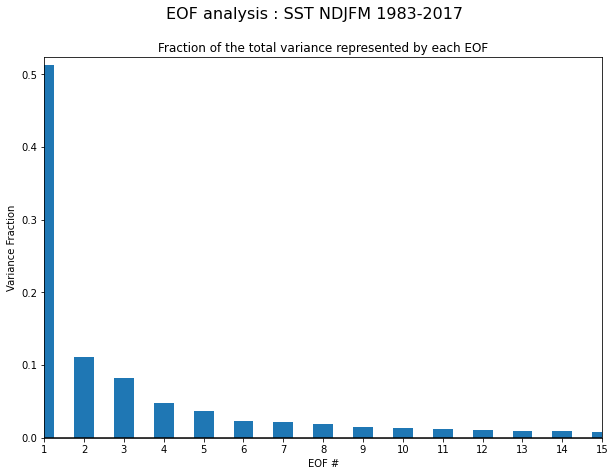

In [30]:
fig = plt.figure(figsize=(10, 7))
fig.suptitle('EOF analysis : SST NDJFM '+ str(year1)+'-'+str(year2), fontsize=16)

eof_num = range(1, 16)
plt.bar(eof_num, varfrac[0:15], width=0.5)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)
plt.show()

figname=dir_figs+'varfrac_sst_ndjfm_pac'
fig.savefig(figname+'.png', bbox_inches='tight')

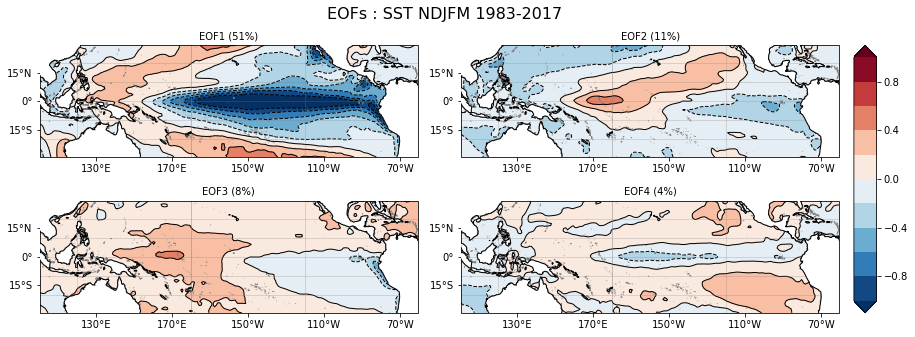

In [31]:
axes_class = (GeoAxes, dict(map_projection=proj))
fig = plt.figure(figsize=(15,5))
fig.suptitle('EOFs : SST NDJFM '+ str(year1)+'-'+str(year2), fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode

clevs = np.linspace(-1, 1, 11)
                   
for i, ax in enumerate(axgr):
    plot_background(ax)
    ax.set_title('EOF'+str(i+1)+' ('+str(int(varfrac[i]*100))+'%)', fontsize=10, loc='center')
    cf = ax.contourf(lon, lat, eofs[i], clevs, transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both')
    c = ax.contour(lon, lat, eofs[i], levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
    axgr.cbar_axes[i].colorbar(cf)

plt.show()

figname=dir_figs+'eofs_sst_ndjfm_pac'
fig.savefig(figname+'.png', bbox_inches='tight')

In [32]:
years = range(year1, year2+1)

xi = [i for i in range(year1, year2+1,5)]

def plot_pc(ax):
    plt.xlabel('Year')
    plt.axhline(0, color='k')
    plt.xlim(year1, year2+1)
    plt.xticks(xi, range(year1, year2+1,5))
    ax.axvline(1980, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(1990, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(2000, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(2010, color='grey', linestyle='--', linewidth=0.5)
    plt.ylim(-120, 120)
    return ax

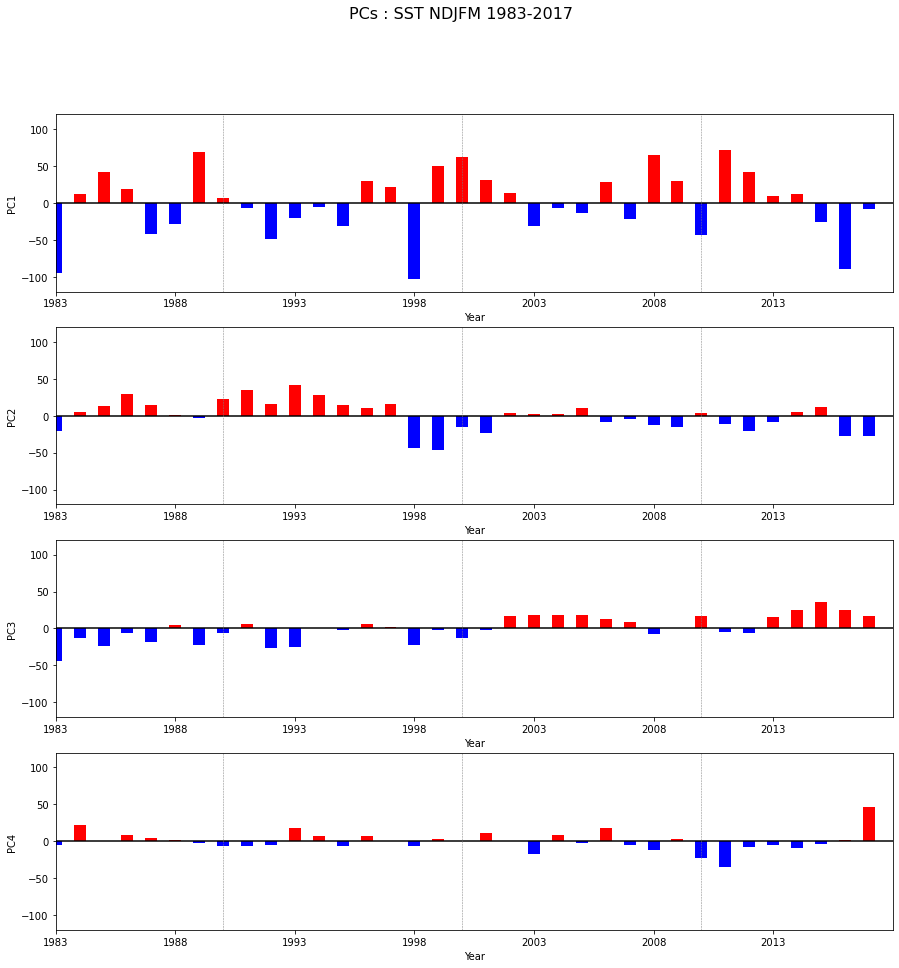

In [33]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('PCs : SST NDJFM '+ str(year1)+'-'+str(year2), fontsize=16)

ax = fig.add_subplot(411)
plt.ylabel('PC1')
plot_pc(ax)
colormat=np.where(pcs[:,0]>0, 'red','blue')
plt.bar(years, pcs[:,0], width=0.5, color=colormat)

ax = fig.add_subplot(412)
plt.ylabel('PC2')
plot_pc(ax)
colormat=np.where(pcs[:,1]>0, 'red','blue')
plt.bar(years, pcs[:,1], width=0.5, color=colormat)

ax = fig.add_subplot(413)
plt.ylabel('PC3')
plot_pc(ax)
colormat=np.where(pcs[:,2]>0, 'red','blue')
plt.bar(years, pcs[:,2], width=0.5, color=colormat)

ax = fig.add_subplot(414)
plt.ylabel('PC4')
plot_pc(ax)
colormat=np.where(pcs[:,3]>0, 'red','blue')
plt.bar(years, pcs[:,3], width=0.5, color=colormat)

plt.show()

figname=dir_figs+'pcs_sst_ndjfm_atl'
fig.savefig(figname+'.png', bbox_inches='tight')

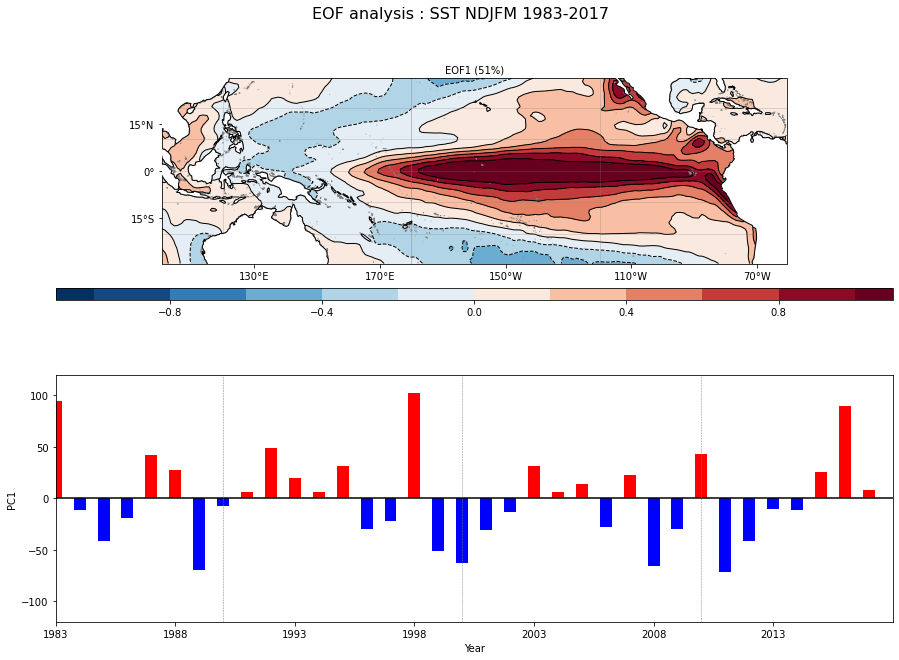

In [34]:
fig = plt.figure(figsize=(15, 10))
fig.suptitle('EOF analysis : SST NDJFM '+ str(year1)+'-'+str(year2), fontsize=16)
ax = fig.add_subplot(211, projection=proj)
plt.title('EOF1 ('+str(int(varfrac[0]*100))+'%)', fontsize=10, loc='center')
plot_background(ax)
cf = ax.contourf(lon, lat, eofs[0]*(-1), levels=clevs, transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both')
c = ax.contour(lon, lat, eofs[0]*(-1), levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.10, extendrect='True')

ax = fig.add_subplot(212)
plt.ylabel('PC1')
plot_pc(ax)
colormat=np.where(pcs[:,0]<0, 'red','blue')
plt.bar(years, pcs[:,0]*(-1), width=0.5, color=colormat)

plt.show()

figname=dir_figs+'eof1_pc1_sst_ndjfm_pac'
fig.savefig(figname+'.png', bbox_inches='tight')

# Bonus : étude de l'Indian Ocean Dipole (IOD)

https://stateoftheocean.osmc.noaa.gov/sur/ind/dmi.php

In [35]:
iod_file = dir_data+'dmi.nc'
iod = xr.open_dataset(iod_file)
print(iod)
dmi=iod['DMI']
time_iod=dmi.WEDCEN2.values
print(dmi)
dmi_smooth=dmi.rolling(WEDCEN2=3, center=True).mean()
print(dmi_smooth)

<xarray.Dataset>
Dimensions:  (WEDCEN2: 2153)
Coordinates:
  * WEDCEN2  (WEDCEN2) datetime64[ns] 1981-11-04 1981-11-11 ... 2023-02-01
Data variables:
    DMI      (WEDCEN2) float64 ...
Attributes:
    history:      FERRET V7.3 (optimized) 16-Feb-23
    Conventions:  CF-1.6
<xarray.DataArray 'DMI' (WEDCEN2: 2153)>
array([-0.062497, -0.278864, -0.394537, ..., -0.256157, -0.052783, -0.181254])
Coordinates:
  * WEDCEN2  (WEDCEN2) datetime64[ns] 1981-11-04 1981-11-11 ... 2023-02-01
Attributes:
    long_name:  Dipole Mode Index (base period 1982-2005, data from OISST)
    units:      degC
<xarray.DataArray 'DMI' (WEDCEN2: 2153)>
array([        nan, -0.24529924, -0.34777018, ...,  0.00685336,
       -0.16339778,         nan])
Coordinates:
  * WEDCEN2  (WEDCEN2) datetime64[ns] 1981-11-04 1981-11-11 ... 2023-02-01
Attributes:
    long_name:  Dipole Mode Index (base period 1982-2005, data from OISST)
    units:      degC


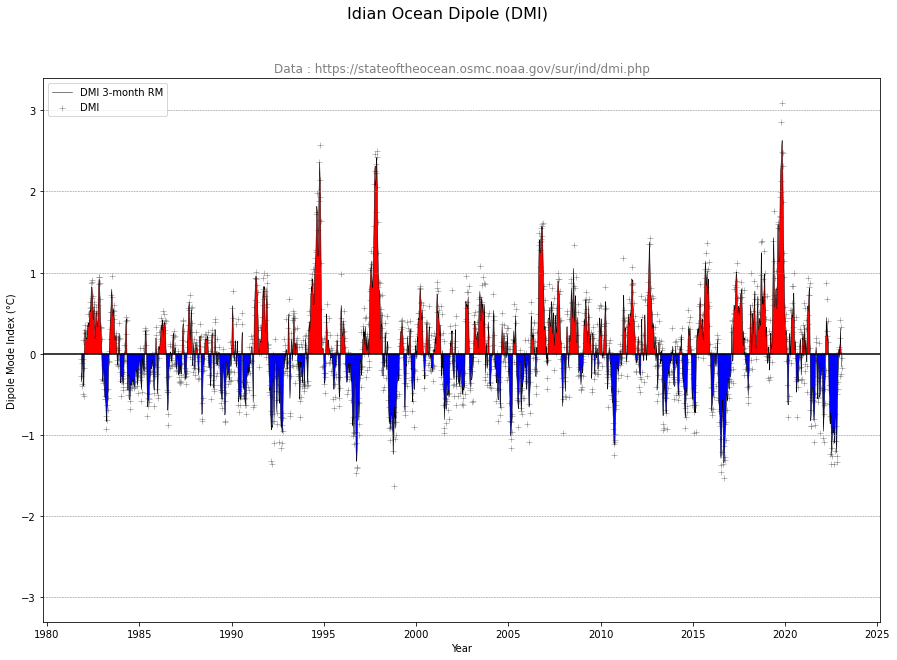

In [36]:
fig=plt.figure(figsize=(15, 10))
fig.suptitle('Idian Ocean Dipole (DMI)', fontsize=16)
plt.title('Data : https://stateoftheocean.osmc.noaa.gov/sur/ind/dmi.php' , fontsize=12, color='grey')
plt.xlabel('Year')
plt.ylabel('Dipole Mode Index (°C)')

ax = plt.scatter(time_iod, dmi, color='grey', linewidth=0.5, alpha=1, marker = '+', label='DMI')
ax = plt.plot(time_iod, dmi_smooth, color='k', linewidth=0.5, alpha=1, label='DMI 3-month RM')

plt.fill_between(time_iod, dmi_smooth, where=dmi_smooth > 0, facecolor='red', interpolate=True)
plt.fill_between(time_iod, dmi_smooth, where=dmi_smooth < 0, facecolor='blue', interpolate=True)

plt.axhline(0, color='k')
plt.axhline(1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(3, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-3, color='grey', linestyle='--', linewidth=0.5)
plt.legend()

figname='./figs/iod'
fig.savefig(figname+'.png',bbox_inches='tight')

plt.show()